## Enhanced model one

Add stochastic effects to model random fluctuations
Include bacterial biofilm formation
Model different growth phases (lag, exponential, stationary)
Add drug degradation/metabolism
Include antibiotic post-antibiotic effects
Model bacterial persistence (dormant states)


More Realistic PK/PD Parameters:


Use population-based parameters with variability
Include circadian rhythms in drug metabolism
Account for organ function (liver, kidney) in drug clearance
Model protein binding effects on drug availability


Environmental Factors:


pH effects on drug activity
Oxygen availability
Nutrient availability

In [1]:
import numpy as np
from scipy.integrate import solve_ivp

def population_ode_enhanced(t, state):
    # Unpack state vector
    S, R, N, A = state  # S: sensitive, R: resistant, N: neutrophils, A: antibodies
    
    # Get drug concentrations at time t
    conc_vanco_t = np.interp(t, time, conc_vancomycin)
    conc_linez_t = np.interp(t, time, conc_linezolid)
    
    # Drug interaction factor (synergy/antagonism)
    interaction_factor = 1.2  # >1 for synergy, <1 for antagonism
    
    # Enhanced drug effect calculation
    drug_effect_vanco = max_drug_effect_vanco * (conc_vanco_t / (conc_vanco_t + EC50_vanco))
    drug_effect_linez = max_drug_effect_linez * (conc_linez_t / (conc_linez_t + EC50_linez))
    combined_drug_effect = interaction_factor * (drug_effect_vanco + drug_effect_linez)
    
    # Immune response effects
    neutrophil_killing = k_neutrophil * N * (S + R)
    antibody_enhancement = (1 + k_antibody * A)
    
    # Horizontal gene transfer
    transfer_rate = hgt_rate * S * R
    
    # Population dynamics with immune response
    dSdt = (rho_sensitive * S * (1 - (S + R) / k) * 
            (1 - combined_drug_effect) * antibody_enhancement - 
            delta_sensitive * S - neutrophil_killing * S - transfer_rate)
    
    dRdt = (rho_resistant * R * (1 - (S + R) / k) * 
            (1 - resistance_factor * combined_drug_effect) * antibody_enhancement - 
            delta_resistant * R - neutrophil_killing * R + transfer_rate)
    
    # Immune response dynamics
    dNdt = alpha_N * (S + R) / (K_N + S + R) - delta_N * N
    dAdt = alpha_A * (S + R) / (K_A + S + R) - delta_A * A
    
    return [dSdt, dRdt, dNdt, dAdt]

# New parameters for enhanced model
params = {
    # Immune response parameters
    'k_neutrophil': 0.1,  # Neutrophil killing rate
    'k_antibody': 0.05,   # Antibody enhancement factor
    'alpha_N': 0.2,       # Neutrophil production rate
    'delta_N': 0.1,       # Neutrophil death rate
    'K_N': 1e4,          # Half-saturation constant for neutrophil response
    'alpha_A': 0.1,       # Antibody production rate
    'delta_A': 0.05,      # Antibody decay rate
    'K_A': 1e4,          # Half-saturation constant for antibody response
    
    # Drug interaction parameters
    'EC50_vanco': 0.03,
    'EC50_linez': 0.02,
    'max_drug_effect_vanco': 0.8,
    'max_drug_effect_linez': 0.7,
    
    # Resistance parameters
    'resistance_factor': 0.5,  # How much resistance reduces drug effectiveness
    'hgt_rate': 1e-6,         # Horizontal gene transfer rate
}

## Enhanced model two

This enhanced model includes several types of stochastic effects:

Demographic Stochasticity


Random variations in birth/death processes
Scales with square root of population size
More important for small populations


Environmental Stochasticity


Wiener process (Brownian motion) for continuous environmental fluctuations
Affects both populations independently
Represents random environmental conditions


Drug Effect Variability


Random fluctuations in drug effectiveness
Models variations in drug absorption and effect
10% variation in drug effectiveness


Growth Rate Variability


Random fluctuations in growth rates
Represents variations in local conditions
5% variation in growth rates

In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def population_ode_resistance(t, state):
    """
    State vector contains populations with different resistance patterns:
    SS: Sensitive to both drugs
    SR: Sensitive to vancomycin, Resistant to linezolid
    RS: Resistant to vancomycin, Sensitive to linezolid
    RR: Resistant to both drugs
    """
    SS, SR, RS, RR = state
    
    # Get drug concentrations at time t
    conc_vanco_t = np.interp(t, time, conc_vancomycin)
    conc_linez_t = np.interp(t, time, conc_linezolid)
    
    # Total population
    N_total = SS + SR + RS + RR
    
    # Drug effects for each drug
    vanco_effect = max_drug_effect_vanco * (conc_vanco_t / (conc_vanco_t + EC50_vanco))
    linez_effect = max_drug_effect_linez * (conc_linez_t / (conc_linez_t + EC50_linez))
    
    # Population dynamics for each subpopulation
    dSSdt = (
        SS * (
            rho_sensitive * (1 - N_total/k) *
            (1 - vanco_effect) * (1 - linez_effect) -
            delta_sensitive
        ) -
        mutation_rate_vanco * SS -  # Mutation to vancomycin resistance
        mutation_rate_linez * SS    # Mutation to linezolid resistance
    )
    
    dSRdt = (
        SR * (
            rho_partial * (1 - N_total/k) *
            (1 - vanco_effect) * (1 - resistance_factor_linez * linez_effect) -
            delta_partial
        ) +
        mutation_rate_linez * SS -  # Gained from SS mutations
        mutation_rate_vanco * SR    # Can mutate to RR
    )
    
    dRSdt = (
        RS * (
            rho_partial * (1 - N_total/k) *
            (1 - resistance_factor_vanco * vanco_effect) * (1 - linez_effect) -
            delta_partial
        ) +
        mutation_rate_vanco * SS -  # Gained from SS mutations
        mutation_rate_linez * RS    # Can mutate to RR
    )
    
    dRRdt = (
        RR * (
            rho_resistant * (1 - N_total/k) *
            (1 - resistance_factor_vanco * vanco_effect) * 
            (1 - resistance_factor_linez * linez_effect) -
            delta_resistant
        ) +
        mutation_rate_vanco * SR +  # Gained from SR mutations
        mutation_rate_linez * RS    # Gained from RS mutations
    )
    
    return [dSSdt, dSRdt, dRSdt, dRRdt]

# Model parameters
params = {
    # Growth rates
    'rho_sensitive': 0.15,    # Fully sensitive strain
    'rho_partial': 0.20,      # Partially resistant strains
    'rho_resistant': 0.25,    # Fully resistant strain
    
    # Death rates
    'delta_sensitive': 0.006,
    'delta_partial': 0.004,
    'delta_resistant': 0.003,
    
    # Carrying capacity
    'k': 10e5,
    
    # Drug effectiveness parameters
    'EC50_vanco': 0.03,
    'EC50_linez': 0.02,
    'max_drug_effect_vanco': 0.8,
    'max_drug_effect_linez': 0.7,
    
    # Resistance factors (how much resistance reduces drug effectiveness)
    'resistance_factor_vanco': 0.3,  # Vancomycin resistance strength
    'resistance_factor_linez': 0.2,  # Linezolid resistance strength
    
    # Mutation rates
    'mutation_rate_vanco': 1e-6,
    'mutation_rate_linez': 1e-7,
}

def simulate_resistance_dynamics(
    initial_conditions=(1e4, 1e2, 1e2, 1e1),  # SS, SR, RS, RR
    total_simulation_time=300,
    treatment_params=None
):
    """
    Simulate bacterial populations with different resistance patterns
    """
    if treatment_params is None:
        treatment_params = {
            'no_drug_period': 72,
            'vancomycin_duration': 6*24,
            'linezolid_duration': 8*24,
        }
    
    # Update global parameters
    globals().update(params)
    
    # Solve the system
    solution = solve_ivp(
        population_ode_resistance,
        [0, total_simulation_time],
        initial_conditions,
        t_eval=np.linspace(0, total_simulation_time, total_simulation_time),
        method='RK45',
        rtol=1e-6,
        atol=1e-6
    )
    
    # Plotting
    plt.figure(figsize=(15, 12))
    
    # Population dynamics
    plt.subplot(2, 1, 1)
    plt.semilogy(solution.t, solution.y[0], 'g-', label='Sensitive to Both')
    plt.semilogy(solution.t, solution.y[1], 'b-', label='Vanc-S, Lin-R')
    plt.semilogy(solution.t, solution.y[2], 'y-', label='Vanc-R, Lin-S')
    plt.semilogy(solution.t, solution.y[3], 'r-', label='Resistant to Both')
    plt.grid(True)
    plt.legend()
    plt.title('Population Dynamics with Different Resistance Patterns')
    plt.xlabel('Time (hours)')
    plt.ylabel('Population (log scale)')
    
    # Drug concentrations
    plt.subplot(2, 1, 2)
    plt.plot(time, conc_vancomycin, 'b-', label='Vancomycin')
    plt.plot(time, conc_linezolid, 'r-', label='Linezolid')
    plt.grid(True)
    plt.legend()
    plt.title('Drug Concentrations')
    plt.xlabel('Time (hours)')
    plt.ylabel('Concentration')
    
    plt.tight_layout()
    
    return solution

# Calculate resistance fractions over time
def analyze_resistance_patterns(solution):
    """Calculate and return resistance statistics over time"""
    total_pop = np.sum(solution.y, axis=0)
    
    resistance_stats = {
        'fraction_any_resistance': (solution.y[1] + solution.y[2] + solution.y[3]) / total_pop,
        'fraction_dual_resistance': solution.y[3] / total_pop,
        'fraction_vanc_resistance': (solution.y[2] + solution.y[3]) / total_pop,
        'fraction_lin_resistance': (solution.y[1] + solution.y[3]) / total_pop
    }
    
    return resistance_stats

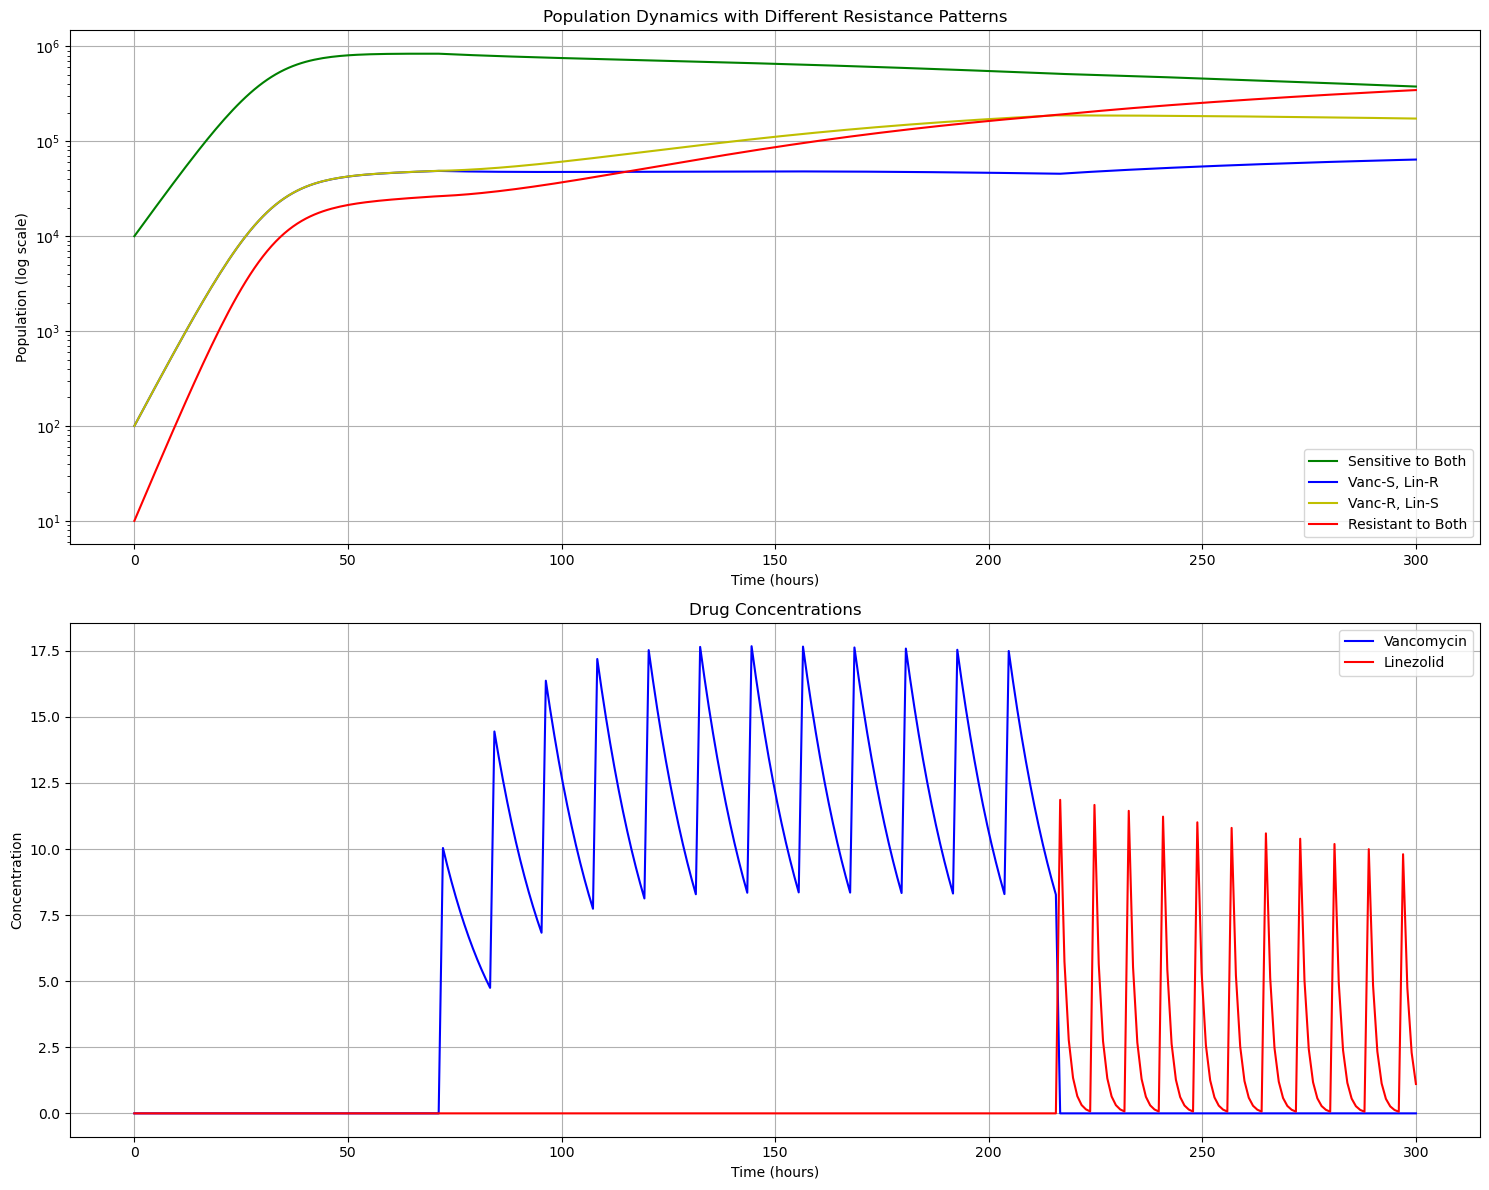

In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def concentration(t, D, V, Ke, tau, start_time, end_time, dosing_times=None):
    """Calculate drug concentration over time"""
    conc = np.zeros_like(t)
    if dosing_times is None:
        # If no specific dosing times, create regular dosing schedule
        dosing_times = np.arange(start_time, end_time, tau)
    
    for i, time_point in enumerate(t):
        if start_time <= time_point <= end_time:
            # Calculate contribution from each dose
            for dose_time in dosing_times:
                if time_point >= dose_time:
                    conc[i] += (D / V) * np.exp(-Ke * (time_point - dose_time))
    return conc

def Ke_Vancomycin(sCr, Age, weight, V=49):
    """Calculate vancomycin elimination rate"""
    eCCr = (140 - Age)*weight/(72*sCr)
    Vanco_CL = (60*eCCr)/(1000*1.08)  # l/hr
    Kel = (Vanco_CL/V)  # hr-1
    return Kel

def Ke_Linezolid(CrCL, V):
    """Calculate linezolid elimination rate"""
    CL_linezolid = 5 + (CrCL * 0.4)
    Kel = CL_linezolid / V
    return Kel

def population_ode_resistance(t, state):
    """
    State vector contains populations with different resistance patterns:
    SS: Sensitive to both drugs
    SR: Sensitive to vancomycin, Resistant to linezolid
    RS: Resistant to vancomycin, Sensitive to linezolid
    RR: Resistant to both drugs
    """
    SS, SR, RS, RR = state
    
    # Get drug concentrations at time t
    conc_vanco_t = np.interp(t, time, conc_vancomycin)
    conc_linez_t = np.interp(t, time, conc_linezolid)
    
    # Total population
    N_total = SS + SR + RS + RR
    
    # Drug effects for each drug
    vanco_effect = max_drug_effect_vanco * (conc_vanco_t / (conc_vanco_t + EC50_vanco))
    linez_effect = max_drug_effect_linez * (conc_linez_t / (conc_linez_t + EC50_linez))
    
    # Population dynamics for each subpopulation
    dSSdt = (
        SS * (
            rho_sensitive * (1 - N_total/k) *
            (1 - vanco_effect) * (1 - linez_effect) -
            delta_sensitive
        ) -
        mutation_rate_vanco * SS -  # Mutation to vancomycin resistance
        mutation_rate_linez * SS    # Mutation to linezolid resistance
    )
    
    dSRdt = (
        SR * (
            rho_partial * (1 - N_total/k) *
            (1 - vanco_effect) * (1 - resistance_factor_linez * linez_effect) -
            delta_partial
        ) +
        mutation_rate_linez * SS -  # Gained from SS mutations
        mutation_rate_vanco * SR    # Can mutate to RR
    )
    
    dRSdt = (
        RS * (
            rho_partial * (1 - N_total/k) *
            (1 - resistance_factor_vanco * vanco_effect) * (1 - linez_effect) -
            delta_partial
        ) +
        mutation_rate_vanco * SS -  # Gained from SS mutations
        mutation_rate_linez * RS    # Can mutate to RR
    )
    
    dRRdt = (
        RR * (
            rho_resistant * (1 - N_total/k) *
            (1 - resistance_factor_vanco * vanco_effect) * 
            (1 - resistance_factor_linez * linez_effect) -
            delta_resistant
        ) +
        mutation_rate_vanco * SR +  # Gained from SR mutations
        mutation_rate_linez * RS    # Gained from RS mutations
    )
    
    return [dSSdt, dSRdt, dRSdt, dRRdt]

# Drug and patient parameters
drug_params = {
    'sCr': 1.3,
    'Age': 60,
    'weight': 70,
    'V_vancomycin': 49,
    'V_linezolid': 40,
    'D_vancomycin': 500,  # mg
    'D_linezolid': 800,   # mg
    'tau_vancomycin': 12, # hours
    'tau_linezolid': 8,   # hours
}

# Model parameters
model_params = {
    # Growth rates
    'rho_sensitive': 0.15,    # Fully sensitive strain
    'rho_partial': 0.20,      # Partially resistant strains
    'rho_resistant': 0.25,    # Fully resistant strain
    
    # Death rates
    'delta_sensitive': 0.006,
    'delta_partial': 0.004,
    'delta_resistant': 0.003,
    
    # Carrying capacity
    'k': 10e5,
    
    # Drug effectiveness parameters
    'EC50_vanco': 0.03,
    'EC50_linez': 0.02,
    'max_drug_effect_vanco': 0.8,
    'max_drug_effect_linez': 0.7,
    
    # Resistance factors
    'resistance_factor_vanco': 0.3,
    'resistance_factor_linez': 0.2,
    
    # Mutation rates
    'mutation_rate_vanco': 1e-6,
    'mutation_rate_linez': 1e-7,
}

def simulate_resistance_dynamics(
    initial_conditions=(1e4, 1e2, 1e2, 1e1),  # SS, SR, RS, RR
    total_simulation_time=300,
    treatment_params=None
):
    """Simulate bacterial populations with different resistance patterns"""
    if treatment_params is None:
        treatment_params = {
            'no_drug_period': 72,
            'vancomycin_duration': 6*24,
            'linezolid_duration': 8*24,
        }
    
    # Update global parameters
    globals().update(model_params)
    globals().update(drug_params)
    
    # Calculate elimination rates
    global Ke_vanco, Ke_linez
    Ke_vanco = Ke_Vancomycin(sCr, Age, weight, V_vancomycin)
    CrCL = (140 - Age)*weight / (72 * sCr)
    Ke_linez = Ke_Linezolid(CrCL, V_linezolid)
    
    # Calculate time points and drug concentrations
    global time, conc_vancomycin, conc_linezolid
    time = np.linspace(0, total_simulation_time, total_simulation_time)
    
    # Calculate drug concentrations
    conc_vancomycin = concentration(
        time, D_vancomycin, V_vancomycin, Ke_vanco, tau_vancomycin,
        treatment_params['no_drug_period'],
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration']
    )
    
    conc_linezolid = concentration(
        time, D_linezolid, V_linezolid, Ke_linez, tau_linezolid,
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration'],
        treatment_params['no_drug_period'] + treatment_params['vancomycin_duration'] + 
        treatment_params['linezolid_duration']
    )
    
    # Solve the system
    solution = solve_ivp(
        population_ode_resistance,
        [0, total_simulation_time],
        initial_conditions,
        t_eval=time,
        method='RK45',
        rtol=1e-6,
        atol=1e-6
    )
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Population dynamics
    ax1.semilogy(solution.t, solution.y[0], 'g-', label='Sensitive to Both')
    ax1.semilogy(solution.t, solution.y[1], 'b-', label='Vanc-S, Lin-R')
    ax1.semilogy(solution.t, solution.y[2], 'y-', label='Vanc-R, Lin-S')
    ax1.semilogy(solution.t, solution.y[3], 'r-', label='Resistant to Both')
    ax1.grid(True)
    ax1.legend()
    ax1.set_title('Population Dynamics with Different Resistance Patterns')
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Population (log scale)')
    
    # Drug concentrations
    ax2.plot(time, conc_vancomycin, 'b-', label='Vancomycin')
    ax2.plot(time, conc_linezolid, 'r-', label='Linezolid')
    ax2.grid(True)
    ax2.legend()
    ax2.set_title('Drug Concentrations')
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Concentration')
    
    plt.tight_layout()
    plt.show()
    
    return solution, fig

# Run the simulation
solution, fig = simulate_resistance_dynamics()

In [ ]:
solution, fig = simulate_resistance_dynamics()

## Enhanced model three:

Key changes in this enhanced model:

Multiple Resistance States:


SS: Sensitive to both drugs
SR: Sensitive to vancomycin, resistant to linezolid
RS: Resistant to vancomycin, sensitive to linezolid
RR: Resistant to both drugs


Drug-Specific Parameters:


Separate EC50 values for each drug
Different maximum effects
Drug-specific resistance factors


Population-Specific Parameters:


Different growth rates for each resistance pattern
Different death rates
Fitness costs of resistance


Mutation Dynamics:


Different mutation rates for each drug
Stepwise mutation pathway (must acquire resistance one drug at a time)
Cross-resistance considerations

To use this model: # Run simulation
solution = simulate_resistance_dynamics(
    initial_conditions=(1e4, 1e2, 1e2, 1e1),  # SS, SR, RS, RR
    total_simulation_time=300
)

# Analyze resistance patterns
resistance_stats = analyze_resistance_patterns(so

This will show the complete simulation with:

Four bacterial populations (SS, SR, RS, RR)
Drug concentrations over time
Sequential drug administration (no drugs → vancomycin → linezolid)

Would you like to:

Adjust any of the parameters?
Modify the treatment schedule?
Analyze specific aspects of the resistance dynamics?lution)

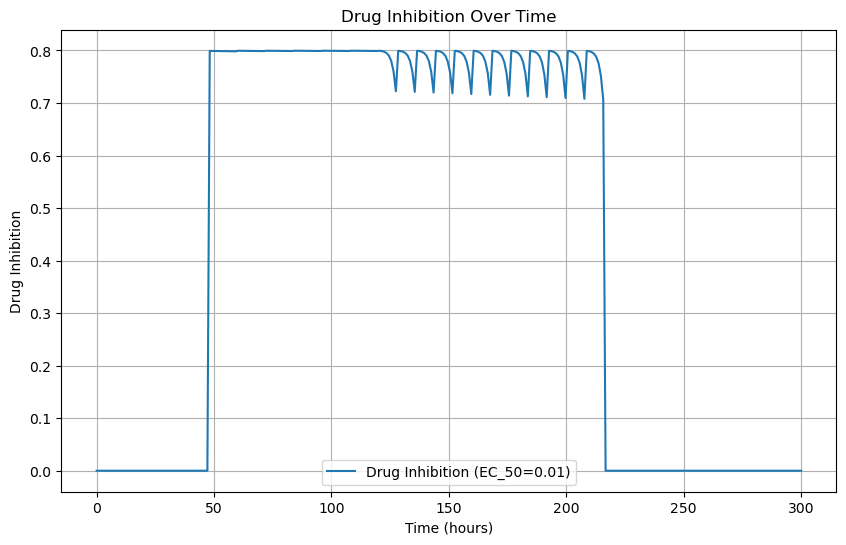

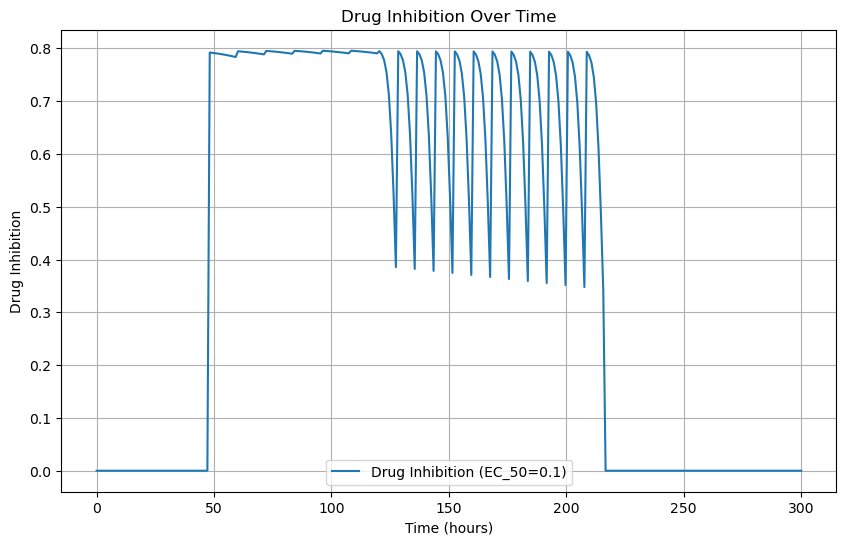

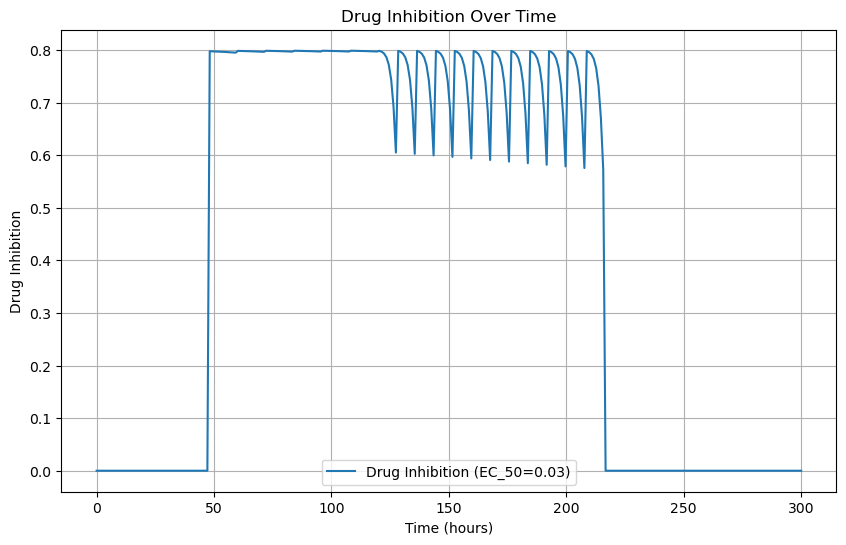

In [9]:
def simulate_drug_dynamics(
    EC_50=0.03,  # Adjust EC_50 here
    initial_sensitive=2,
    initial_resistant=5,
    no_drug_period=48,
    vancomycin_duration=72,
    linezolid_duration=96,
    total_simulation_time=300,
):
    # First, calculate all timing to ensure it fits
    vanco_start = no_drug_period
    vanco_end = vanco_start + vancomycin_duration
    linez_start = vanco_end
    linez_end = linez_start + linezolid_duration

    # Verify timing fits within simulation
    if linez_end > total_simulation_time:
        raise ValueError(f"Total treatment time ({linez_end}h) exceeds simulation time ({total_simulation_time}h)")

    # Patient Specific Parameters
    sCr = 1.3
    Age = 60
    weight = 70
    V_vancomycin = 49
    V_linezolid = 40

    # Calculate Elimination Rates
    Ke_vanco = Ke_Vancomycin(sCr, Age, weight)
    CrCL = (140 - Age) * weight / (72 * sCr)
    Ke_linez = Ke_Linezolid(CrCL, V_linezolid)

    # Time Array
    time = np.linspace(0, total_simulation_time, total_simulation_time)

    # Vancomycin Dosing
    D_vancomycin = 500  # mg
    tau_vancomycin = 12  # hours

    # Linezolid Dosing
    D_linezolid = 800  # mg
    tau_linezolid = 8  # hours

    # Calculate Drug Concentrations
    conc_vancomycin = concentration(
        time, D_vancomycin, V_vancomycin, Ke_vanco, tau_vancomycin,
        vanco_start, vanco_end
    )
    conc_linezolid = concentration(
        time, D_linezolid, V_linezolid, Ke_linez, tau_linezolid,
        linez_start, linez_end
    )

    # Combined concentration both vancomycin and linezolid
    conc_combined = conc_vancomycin + conc_linezolid

    # Population Dynamics Parameters
    max_drug_effect = 0.8

    def population_ode(t, r):
        S, R = r
        conc_t = np.interp(t, time, conc_combined)
        
        drug_inhibition = max_drug_effect * (conc_t / (conc_t + EC_50))
        
        dSdt = rho_sensitive * S * (1 - (S + R) / k) * (1 - drug_inhibition) - delta_sensitive * S
        dRdt = rho_resistant * R * (1 - (S + R) / k) * (1 - 0.8 * drug_inhibition) - delta_resistant * R
        
        return [dSdt, dRdt]

    # Solve ODE for population dynamics
    solution = solve_ivp(
        population_ode,
        [0, total_simulation_time],
        [initial_sensitive, initial_resistant],
        dense_output=True,
        t_eval=time,
    )

    # Calculate drug inhibition over time
    drug_inhibition = max_drug_effect * (conc_combined / (conc_combined + EC_50))

    # Plot the drug inhibition
    plt.figure(figsize=(10, 6))
    plt.plot(time, drug_inhibition, label=f'Drug Inhibition (EC_50={EC_50})')
    plt.title('Drug Inhibition Over Time')
    plt.xlabel('Time (hours)')
    plt.ylabel('Drug Inhibition')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the simulation with different EC_50 values
simulate_drug_dynamics(EC_50=0.01)  # Lower EC_50 (more sensitive drug effect)
simulate_drug_dynamics(EC_50=0.1)   # Higher EC_50 (less sensitive drug effect)
simulate_drug_dynamics(EC_50=0.03)  # Default EC_50


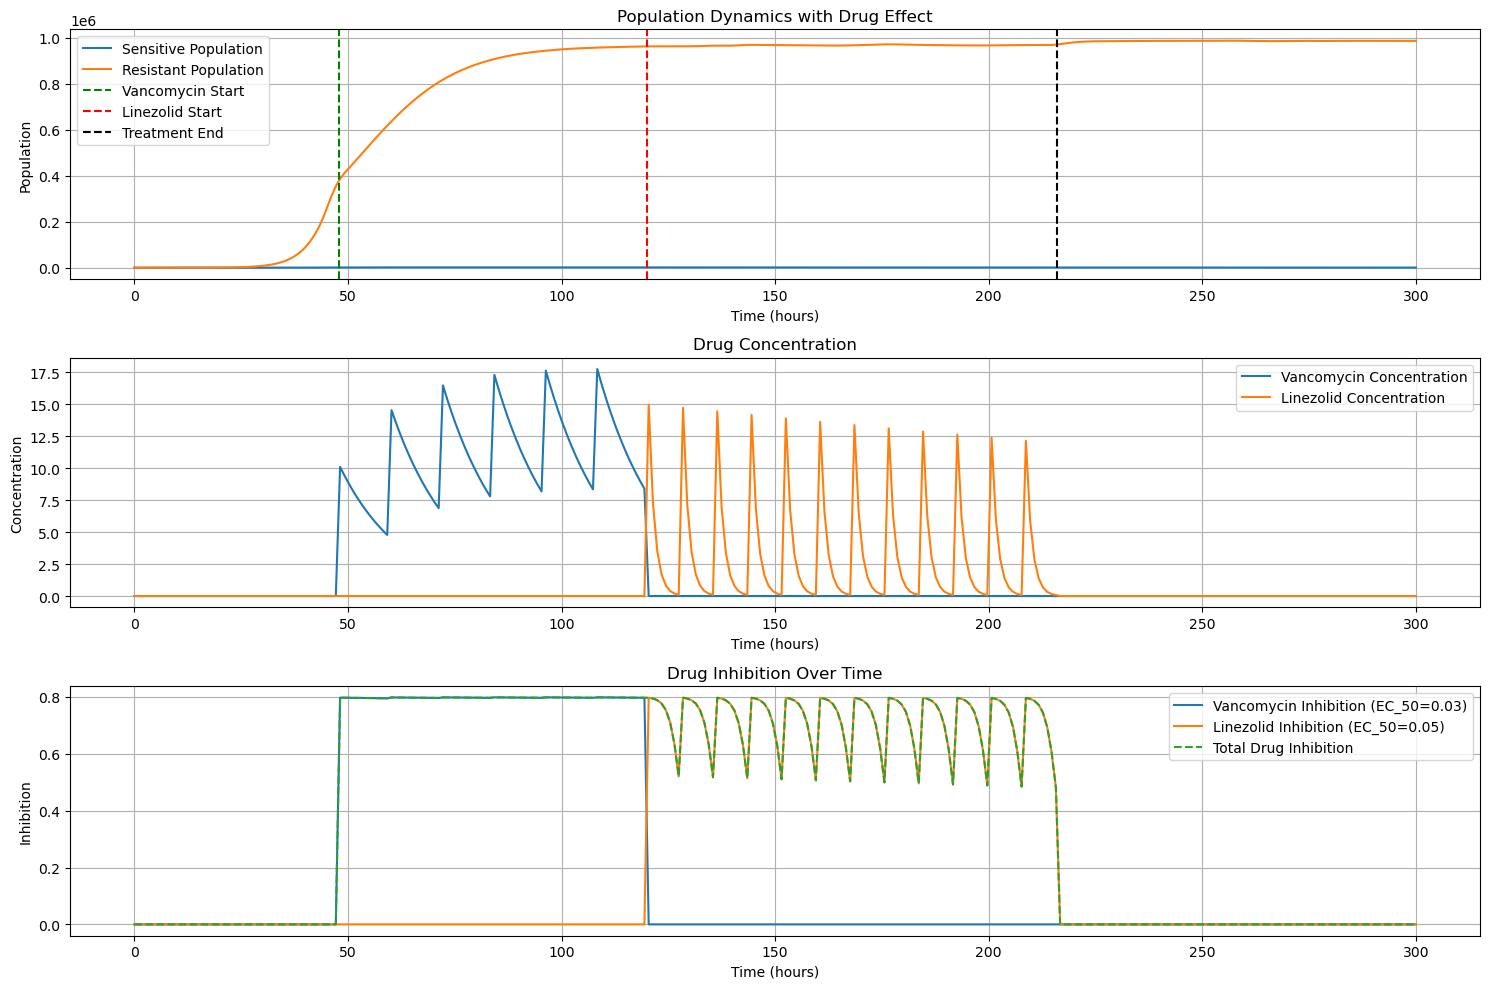

In [11]:
def simulate_drug_dynamics(
    EC_50_vanco=0.03,  # EC50 for vancomycin
    EC_50_linez=0.03,  # EC50 for linezolid
    initial_sensitive=2,
    initial_resistant=5,
    no_drug_period=48,
    vancomycin_duration=72,
    linezolid_duration=96,
    total_simulation_time=300,
):
    # First, calculate all timing to ensure it fits
    vanco_start = no_drug_period
    vanco_end = vanco_start + vancomycin_duration
    linez_start = vanco_end
    linez_end = linez_start + linezolid_duration

    # Verify timing fits within simulation
    if linez_end > total_simulation_time:
        raise ValueError(f"Total treatment time ({linez_end}h) exceeds simulation time ({total_simulation_time}h)")

    # Patient Specific Parameters
    sCr = 1.3
    Age = 60
    weight = 70
    V_vancomycin = 49
    V_linezolid = 40

    # Calculate Elimination Rates
    Ke_vanco = Ke_Vancomycin(sCr, Age, weight)
    CrCL = (140 - Age) * weight / (72 * sCr)
    Ke_linez = Ke_Linezolid(CrCL, V_linezolid)

    # Time Array
    time = np.linspace(0, total_simulation_time, total_simulation_time)

    # Vancomycin Dosing
    D_vancomycin = 500  # mg
    tau_vancomycin = 12  # hours

    # Linezolid Dosing
    D_linezolid = 800  # mg
    tau_linezolid = 8  # hours

    # Calculate Drug Concentrations
    conc_vancomycin = concentration(
        time, D_vancomycin, V_vancomycin, Ke_vanco, tau_vancomycin,
        vanco_start, vanco_end
    )
    conc_linezolid = concentration(
        time, D_linezolid, V_linezolid, Ke_linez, tau_linezolid,
        linez_start, linez_end
    )

    # Combined concentration both vancomycin and linezolid
    conc_combined = conc_vancomycin + conc_linezolid

    # Population Dynamics Parameters
    max_drug_effect = 0.8

    def population_ode(t, r):
        S, R = r
        conc_vanco_t = np.interp(t, time, conc_vancomycin)
        conc_linez_t = np.interp(t, time, conc_linezolid)
        
        # Independent drug inhibition effects
        drug_inhibition_vanco = max_drug_effect * (conc_vanco_t / (conc_vanco_t + EC_50_vanco))
        drug_inhibition_linez = max_drug_effect * (conc_linez_t / (conc_linez_t + EC_50_linez))
        
        # Total drug inhibition
        total_drug_inhibition = drug_inhibition_vanco + drug_inhibition_linez
        
        dSdt = rho_sensitive * S * (1 - (S + R) / k) * (1 - total_drug_inhibition) - delta_sensitive * S
        dRdt = rho_resistant * R * (1 - (S + R) / k) * (1 - 0.8 * total_drug_inhibition) - delta_resistant * R
        
        return [dSdt, dRdt]

    # Solve ODE for population dynamics
    solution = solve_ivp(
        population_ode,
        [0, total_simulation_time],
        [initial_sensitive, initial_resistant],
        dense_output=True,
        t_eval=time,
    )

    # Calculate drug inhibition for plotting
    drug_inhibition_vanco = max_drug_effect * (conc_vancomycin / (conc_vancomycin + EC_50_vanco))
    drug_inhibition_linez = max_drug_effect * (conc_linezolid / (conc_linezolid + EC_50_linez))
    total_drug_inhibition = drug_inhibition_vanco + drug_inhibition_linez

    # Plot the results
    plt.figure(figsize=(15, 10))
    
    # Population dynamics plot
    plt.subplot(3, 1, 1)
    plt.plot(time, solution.y[0], label='Sensitive Population')
    plt.plot(time, solution.y[1], label='Resistant Population')
    plt.axvline(x=vanco_start, color='g', linestyle='--', label='Vancomycin Start')
    plt.axvline(x=vanco_end, color='r', linestyle='--', label='Linezolid Start')
    plt.axvline(x=linez_end, color='k', linestyle='--', label='Treatment End')
    plt.title('Population Dynamics with Drug Effect')
    plt.xlabel('Time (hours)')
    plt.ylabel('Population')
    plt.legend()
    plt.grid(True)

    # Drug concentration plot
    plt.subplot(3, 1, 2)
    plt.plot(time, conc_vancomycin, label='Vancomycin Concentration')
    plt.plot(time, conc_linezolid, label='Linezolid Concentration')
    plt.title('Drug Concentration')
    plt.xlabel('Time (hours)')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)

    # Drug inhibition plot
    plt.subplot(3, 1, 3)
    plt.plot(time, drug_inhibition_vanco, label=f'Vancomycin Inhibition (EC_50={EC_50_vanco})')
    plt.plot(time, drug_inhibition_linez, label=f'Linezolid Inhibition (EC_50={EC_50_linez})')
    plt.plot(time, total_drug_inhibition, label='Total Drug Inhibition', linestyle='--')
    plt.title('Drug Inhibition Over Time')
    plt.xlabel('Time (hours)')
    plt.ylabel('Inhibition')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run the simulation with different EC50 values for vancomycin and linezolid
simulate_drug_dynamics(EC_50_vanco=0.03, EC_50_linez=0.05)  # Example EC50 values


## Key Changes:

Added separate 𝐸𝐶50 values for vancomycin and linezolid: EC_50_vanco and EC_50_linez.
Calculated separate drug inhibition terms for vancomycin and linezolid.
Combined the inhibition terms to compute the total drug inhibition.
Updated the plots to show separate inhibition curves for each drug.


How to Experiment:
Change EC_50_vanco and EC_50_linez to different values to see how they impact drug inhibition curves and population dynamics.
For example:
simulate_drug_dynamics(EC_50_vanco=0.01, EC_50_linez=0.1)
simulate_drug_dynamics(EC_50_vanco=0.05, EC_50_linez=0.02)